## Ensure zfp compression 

In [239]:
# Install pyzfp package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyzfp
from pyzfp import compress, decompress

## Imports

In [240]:
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.self_adjoint import setup_w_over_q
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer
import copy

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# We define 32 bit floating point as the precision type 
dtype = np.float32

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

configuration['language'] = 'openmp'

## Model

In [241]:
# Define dimensions for the interior of the model
nx,nz = 201,201
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define dimensions for the model padded with absorbing boundaries
npad = 50          # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx + 2 * npad, nz + 2 * npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Define the dimensions 
# Note if you do not specify dimensions, you get in order x,y,z
x = SpaceDimension(name='x', spacing=Constant(name='h_x', 
                   value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', 
                   value=extent_pad[1]/(shape_pad[1]-1)))

# Initialize the Devito grid 
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, 
            dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

# NBVAL_IGNORE_OUTPUT

# Create the velocity and buoyancy fields as in the nonlinear notebook 
space_order = 8

# Wholespace velocity
m0 = Function(name='m0', grid=grid, space_order=space_order)
m0.data[:] = 1.5

# Perturbation to velocity: a square offset from the center of the model
dmFwd = Function(name='dmFwd', grid=grid, space_order=space_order)
dmAdj = Function(name='dmAdj', grid=grid, space_order=space_order)
size = 5
x0 = (shape_pad[0]-1)//2
z0 = (shape_pad[1]-1)//2
dmFwd.data[:] = 0.0
dmFwd.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Constant density
b = Function(name='b', grid=grid, space_order=space_order)
b.data[:,:] = 1.0 / 1.0

# Initialize the attenuation profile for Q=100 model
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
qmax = 100.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

def compute_critical_dt(v):
    """
    Determine the temporal sampling to satisfy CFL stability.
    This method replicates the functionality in the Model class.
    Note we add a safety factor, reducing dt by a factor 0.75 due to the
    w/Q attentuation term.
    Parameters
    ----------
    v : Function
        velocity
    """
    coeff = 0.38 if len(v.grid.shape) == 3 else 0.42
    dt = 0.75 * v.dtype(coeff * np.min(v.grid.spacing) / (np.max(v.data)))
    return v.dtype("%.5e" % dt)

shape;            (201, 201)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (2000.0, 2000.0)

shape_pad;        [301 301]
origin_pad;       (-500.0, -500.0)
extent_pad;       (3000.0, 3000.0)

grid.shape;       (301, 301)
grid.extent;      (3000.0, 3000.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


Operator `WOverQ_Operator` run in 0.01 s


## Acquisition geometry

In [242]:
t0 = 0.0     # Simulation time start
tn = 2000.0  # Simulation time end (1 second = 1000 msec)
dt = compute_critical_dt(m0)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min, max, dt, num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))
print("time_range; ", time_range)

# Source
src0 = RickerSource(name='src0', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src0.coordinates.data[0,0] = dx * ((nx-1)//2 - 50)
src0.coordinates.data[0,1] = dz * 2*(nz-1)/3

# Receivers 
rec0 = Receiver(name='rec0', grid=grid, npoint=nz, time_range=time_range)
rec0.coordinates.data[:,0] = dx * ((nx-1)//2 + 50)
rec0.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

rec1 = Receiver(name='rec1', grid=grid, npoint=nz, time_range=time_range)
rec1.coordinates.data[:,0] = dx * ((nx-1)//2 + 50)
rec1.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

Time min, max, dt, num;   0.000000 2000.000000   2.100000 953
time_range;  TimeAxis: start=0, stop=2001.3, step=2.1, num=954


## Plot model

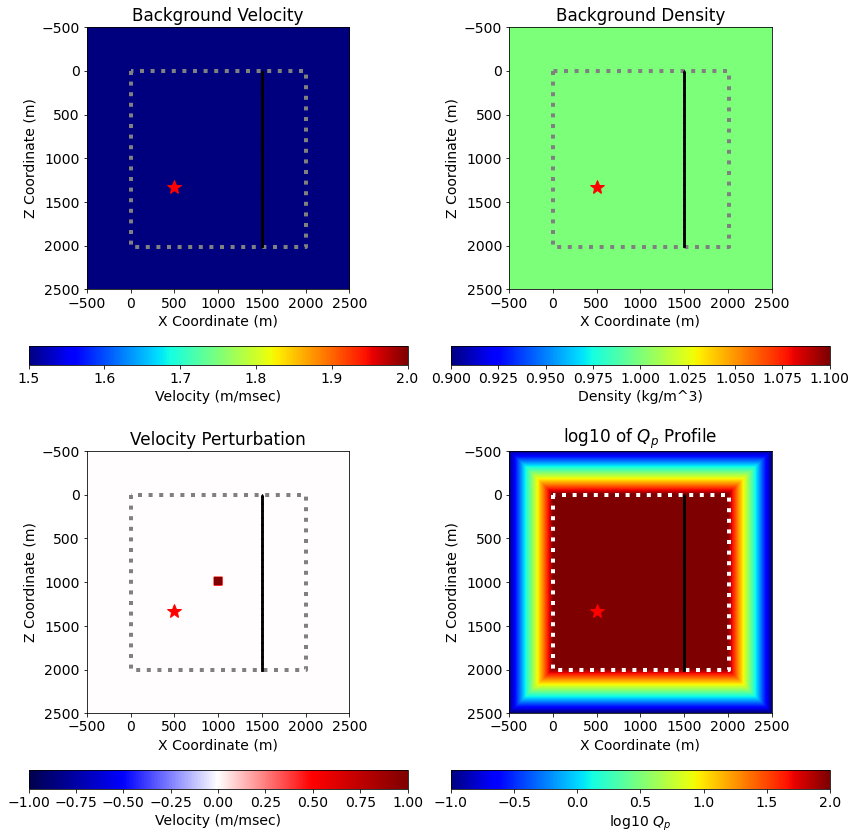

In [243]:
# NBVAL_INGNORE_OUTPUT

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

vmin, vmax = 1.5, 2.0
pmin, pmax = -1, +1
bmin, bmax = 0.9, 1.1

q = w / wOverQ.data[:]

x1 = 0.0
x2 = dx * nx
z1 = 0.0
z2 = dz * nz
abcX = [x1,x1,x2,x2,x1]
abcZ = [z1,z2,z2,z1,z1]

plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.imshow(np.transpose(m0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src0.coordinates.data[:, 0], src0.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec0.coordinates.data[:, 0], rec0.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Velocity")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=bmin, vmax=bmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src0.coordinates.data[:, 0], src0.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec0.coordinates.data[:, 0], rec0.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Density (kg/m^3)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Density")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dmFwd.data), cmap="seismic", 
           vmin=pmin, vmax=pmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src0.coordinates.data[:, 0], src0.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec0.coordinates.data[:, 0], rec0.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity Perturbation")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(np.log10(q.data)), cmap=cm.jet,
           vmin=np.log10(qmin), vmax=np.log10(qmax), extent=plt_extent)
plt.plot(abcX, abcZ, 'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src0.coordinates.data[:, 0], src0.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec0.coordinates.data[:, 0], rec0.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='log10 $Q_p$')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q_p$ Profile")

plt.tight_layout()
None

## Define wavefields

In [244]:
# Define the TimeFunctions for nonlinear and Jacobian operations
nt = time_range.num
u0 = TimeFunction(name="u0", grid=grid, time_order=2, space_order=space_order, save=nt)
du = TimeFunction(name="du", grid=grid, time_order=2, space_order=space_order, save=None)

# Get the dimensions for t, x, z 
t,x,z = u0.dimensions

# Update the dimension spacing_map to include the time dimension
# Please refer to the first implementation notebook for more information
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print(spacing_map)

{h_x: 10.0, h_z: 10.0, dt: 2.1}


## Nonlinear operator

In [245]:
# NBVAL_IGNORE_OUTPUT

# The nonlinear forward time update equation and operator
eq_time_update_nl_fwd = (t.spacing**2 * m0**2 / b) * \
    ((b * u0.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * u0.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u0 + \
    (t.spacing * wOverQ - 1) * u0.backward

stencil_nl = Eq(u0.forward, eq_time_update_nl_fwd)
src_term0 = src0.inject(field=u0.forward, expr=src0 * t.spacing**2 * m0**2 / b)
rec_term0 = rec0.interpolate(expr=u0.forward)
op_nl = Operator([stencil_nl] + src_term0 + rec_term0, subs=spacing_map)

# Run the operator for the nonlinear forward
u0.data[:] = 0
op_nl.apply()

# Copy the unperturbed nonlinear wavefields
rec0_copy = copy.copy(rec0)
u0_copy = copy.copy(u0)

Operator `Kernel` run in 0.18 s


## Jacobian forward and adjoint operators, linearization test
1. compress and de-compress the nonlinear wavefield for a range of tolerances
1. compute SNR of round trip wavefields and use as dictionary keys for storage of results
1. perform linearization tests and save norms and polynomial fits for plotting
1. perform linear adjoint and save computed gradients for plotting below

In [246]:
# NBVAL_IGNORE_OUTPUT

# The linearized forward time update equation and operator
eq_time_update_ln_fwd = (t.spacing**2 * m0**2 / b) * \
    ((b * du.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * du.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + 
     2 * b * dmFwd * m0**-3 * (wOverQ * u0.dt(x0=t-t.spacing/2) + u0.dt2)) +\
    (2 - t.spacing * wOverQ) * du + \
    (t.spacing * wOverQ - 1) * du.backward

stencil_ln_fwd = Eq(du.forward, eq_time_update_ln_fwd)
rec_term1 = rec1.interpolate(expr=du.forward)
op_ln_fwd = Operator([stencil_ln_fwd] + rec_term1, subs=spacing_map)

# The linearized adjoint time update equation and operator
eq_time_update_ln_adj = (t.spacing**2 * m0**2 / b) * \
    ((b * du.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) +
     (b * du.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) +\
    (2 - t.spacing * wOverQ) * du + \
    (t.spacing * wOverQ - 1) * du.forward

stencil_ln_adj = Eq(du.backward, eq_time_update_ln_adj)
dm_update = Eq(dmAdj, dmAdj +
               du * (2 * b * m0**-3 * (wOverQ * u0.dt(x0=t-t.spacing/2) + u0.dt2)))
rec_term_ln_adj = rec1.inject(field=du.backward, expr=rec1 * t.spacing**2 * m0**2 / b)
op_ln_adj = Operator([dm_update] + [stencil_ln_adj] + rec_term_ln_adj, subs=spacing_map)

# set up the nonlinear wavefield for compression
# have to jump through hoops to get zfp to work here ... not sure why
# something about a memoryview maybe
ucopy = np.ones(u0.data.shape, dtype=dtype)
ucopy[:] = u0_copy.data[:,:,:]
size = np.prod(u0_copy.data.shape)

In [247]:
# Inititalize list/dictionary to hold results
snrs = []
toldict = {}
n2dict = {}
p2dict = {}
gdict = {}
ratiodict = {}

# tols = [10.0, 1.0, 0.1, 1.e-6]
tols = [250.0, 10.0, 1.0, 0.1, 0.0]
for tol in tols:
    if tol > 0:
        c = compress(ucopy, tolerance=tol)
        u0.data[:] = decompress(c, u0.data.shape, u0.data.dtype, tolerance=tol)
    else:
        u0.data[:] = ucopy[:]

    print(" ")
    print("u0              min,max,rms; %+12.6f %+12.6f %+12.6f" % (np.min(u0_copy.data[:]), np.max(u0_copy.data[:]), 
                                                                    np.sqrt(np.linalg.norm(u0_copy.data[:]) / size)))    
    print("u0 (round trip) min,max,rms; %+12.6f %+12.6f %+12.6f" % (np.min(u0.data[:]), np.max(u0.data[:]), 
                                                                    np.sqrt(np.linalg.norm(u0.data[:]) / size)))

    if tol > 0:
        snr = 10 * np.log10(np.linalg.norm(u0_copy.data[:]) /  np.linalg.norm(u0_copy.data[:] - u0.data[:]))
        snr = "%05.2f" % snr
    else:
        snr = "inf"
    
    snrs.append(snr)
    print("snr; ", snr)
    toldict.update( {snr : tol} )

    size1 = np.prod(u0.data.shape) * 4
    size2 = len(c) * c.itemsize
    if snr == "inf":
        size2 = size1
    cratio = size1 / size2
    print("size1,size2,ratio; %12.4f %12.4f %12.4f" % (size1, size2, cratio))
    ratiodict.update( {snr : cratio} )

    # Instantiate and run the operator for the linearized forward
    op_ln_fwd = Operator([stencil_ln_fwd] + rec_term1, subs=spacing_map)
    du.data[:] = 0
    op_ln_fwd.apply()

    # NBVAL_IGNORE_OUTPUT
    mm = Function(name='mm', grid=grid, space_order=space_order)

    # Solve F(m + h dm) for sequence of decreasing h
    dh = np.sqrt(2.0)
    h = 0.1
    nstep = 7
    scale = np.empty(nstep)
    norm2 = np.empty(nstep)
    for kstep in range(nstep):
        h = h / dh
        mm.data[:] = m0.data + h * dmFwd.data
        u0.data[:] = 0
        rec0.data[:] = 0
        op_nl.apply(m0=mm)
        scale[kstep] = h
        norm2[kstep] = 0.5 * np.linalg.norm(rec0.data - rec0_copy.data - h * rec1.data)**2

    p2 = np.polyfit(np.log10(scale), np.log10(norm2), 1)
    n2dict.update( {snr : norm2} )
    p2dict.update( {snr : p2[0]} )

    print("\nlinearization F %s (so=%d) -- 2nd (%.1f) = %.4f" %
          (shape, 8, dh**4, p2[0]))
    
    # run the linearized adjoint
    if tol > 0:
        c = compress(ucopy, tolerance=tol)
        u0.data[:] = decompress(c, u0.data.shape, u0.data.dtype, tolerance=tol)
    else:
        u0.data[:] = ucopy[:]

    dmAdj.data[:] = 0
    op_ln_adj.apply()
    gdict.update( {snr : copy.copy(dmAdj)} )
    print("\ngradient min/max; %+12.6f %+12.6f" % (np.min(dmAdj.data[:]), np.max(dmAdj.data[:])))

 
u0              min,max,rms;   -19.433640   +36.659790    +0.005829
u0 (round trip) min,max,rms;   -21.500000   +39.000000    +0.005981
snr;  01.96
size1,size2,ratio; 345733416.0000  263520.0000    1311.9817


Operator `Kernel` run in 0.31 s
Operator `Kernel` run in 0.40 s
Operator `Kernel` run in 0.17 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s



linearization F (201, 201) (so=8) -- 2nd (4.0) = 1.9545


Operator `Kernel` run in 0.24 s



gradient min/max;  -136.302109  +348.243958
 
u0              min,max,rms;   -19.433640   +36.659790    +0.005829
u0 (round trip) min,max,rms;   -19.171875   +36.554688    +0.005835
snr;  09.62
size1,size2,ratio; 345733416.0000  573824.0000     602.5078


Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.20 s
Operator `Kernel` run in 0.23 s



linearization F (201, 201) (so=8) -- 2nd (4.0) = 2.4465


Operator `Kernel` run in 0.52 s



gradient min/max;  -125.130280  +434.145996
 
u0              min,max,rms;   -19.433640   +36.659790    +0.005829
u0 (round trip) min,max,rms;   -19.410156   +36.646484    +0.005830
snr;  16.45
size1,size2,ratio; 345733416.0000 1546936.0000     223.4956


Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s



linearization F (201, 201) (so=8) -- 2nd (4.0) = 3.6042


Operator `Kernel` run in 0.19 s



gradient min/max;  -126.452873  +433.037018
 
u0              min,max,rms;   -19.433640   +36.659790    +0.005829
u0 (round trip) min,max,rms;   -19.431763   +36.655334    +0.005829
snr;  26.50
size1,size2,ratio; 345733416.0000 3927296.0000      88.0334


Operator `Kernel` run in 0.19 s
Operator `Kernel` run in 0.61 s
Operator `Kernel` run in 0.29 s
Operator `Kernel` run in 0.21 s
Operator `Kernel` run in 0.21 s
Operator `Kernel` run in 0.21 s
Operator `Kernel` run in 0.21 s
Operator `Kernel` run in 0.21 s



linearization F (201, 201) (so=8) -- 2nd (4.0) = 3.9295


Operator `Kernel` run in 0.64 s



gradient min/max;  -126.371628  +433.137787
 
u0              min,max,rms;   -19.433640   +36.659790    +0.005829
u0 (round trip) min,max,rms;   -19.433640   +36.659790    +0.005829
snr;  inf
size1,size2,ratio; 345733416.0000 345733416.0000       1.0000


Operator `Kernel` run in 0.17 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.17 s
Operator `Kernel` run in 0.18 s
Operator `Kernel` run in 0.19 s
Operator `Kernel` run in 0.19 s



linearization F (201, 201) (so=8) -- 2nd (4.0) = 3.9357


Operator `Kernel` run in 0.16 s



gradient min/max;  -126.359329  +433.148529


## Plot linearization results

['01.96', '09.62', '16.45', '26.50', 'inf']
snr,p2;  01.96 1.9545497515388122
snr,p2;  09.62 2.4464872576669037
snr,p2;  16.45 3.604200031545125
snr,p2;  26.50 3.9294958375938727
snr,p2;  inf 3.935650458621405


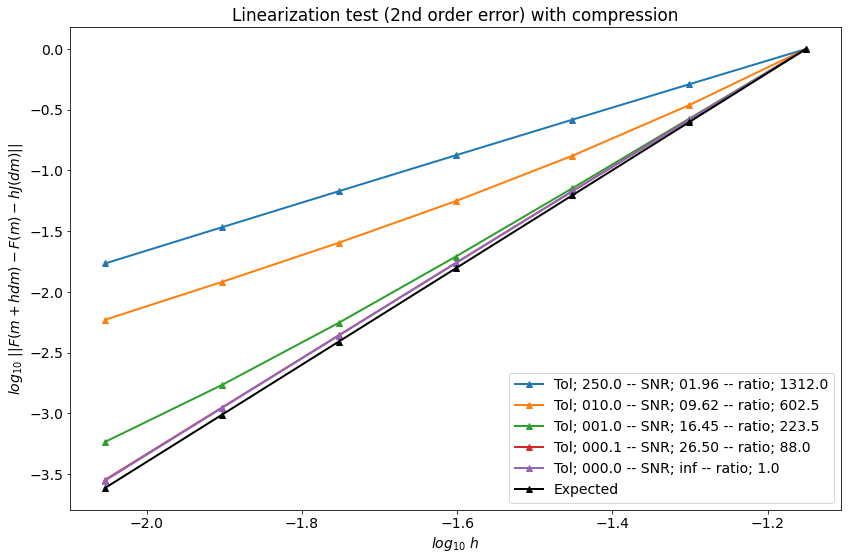

In [248]:
# NBVAL_IGNORE_OUTPUT

print(snrs)

# Plot linearization tests
plt.figure(figsize=(12,8))

expected2 = np.empty(nstep)
expected2[0] = norm2[0]

for kstep in range(1, nstep):
    expected2[kstep] = expected2[kstep - 1] / (dh**4)

msize = 10

for snr in snrs:
#     if snr != "inf":
    print("snr,p2; ", snr, p2dict[snr])
    norms2 = n2dict[snr]
    label = 'Tol; %05.1f -- SNR; %s -- ratio; %.1f' % (toldict[snr], snr, ratiodict[snr])
    plt.plot(np.log10(scale), np.log10(norms2) - np.log10(norms2[0]), label=label, linewidth=2, marker="^")

plt.plot(np.log10(scale), np.log10(expected2) - np.log10(expected2[0]), label='Expected', color="black", linewidth=2, marker="^")

plt.xlabel('$log_{10}\ h$')
plt.ylabel('$log_{10}\ \|| F(m+h dm) - F(m) - h J(dm)\||$')
plt.title('Linearization test (2nd order error) with compression')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Plot gradients

amax;  434.146
dot,ninf,n,angr,angd; +1.123071e+07 +4.126780e+03 +2.995989e+03    +0.431462   +24.720946
dot,ninf,n,angr,angd; +1.698604e+07 +4.126780e+03 +4.118468e+03    +0.034255    +1.962640
dot,ninf,n,angr,angd; +1.703973e+07 +4.126780e+03 +4.129108e+03    +0.004797    +0.274825
dot,ninf,n,angr,angd; +1.703031e+07 +4.126780e+03 +4.126780e+03    +0.000488    +0.027976


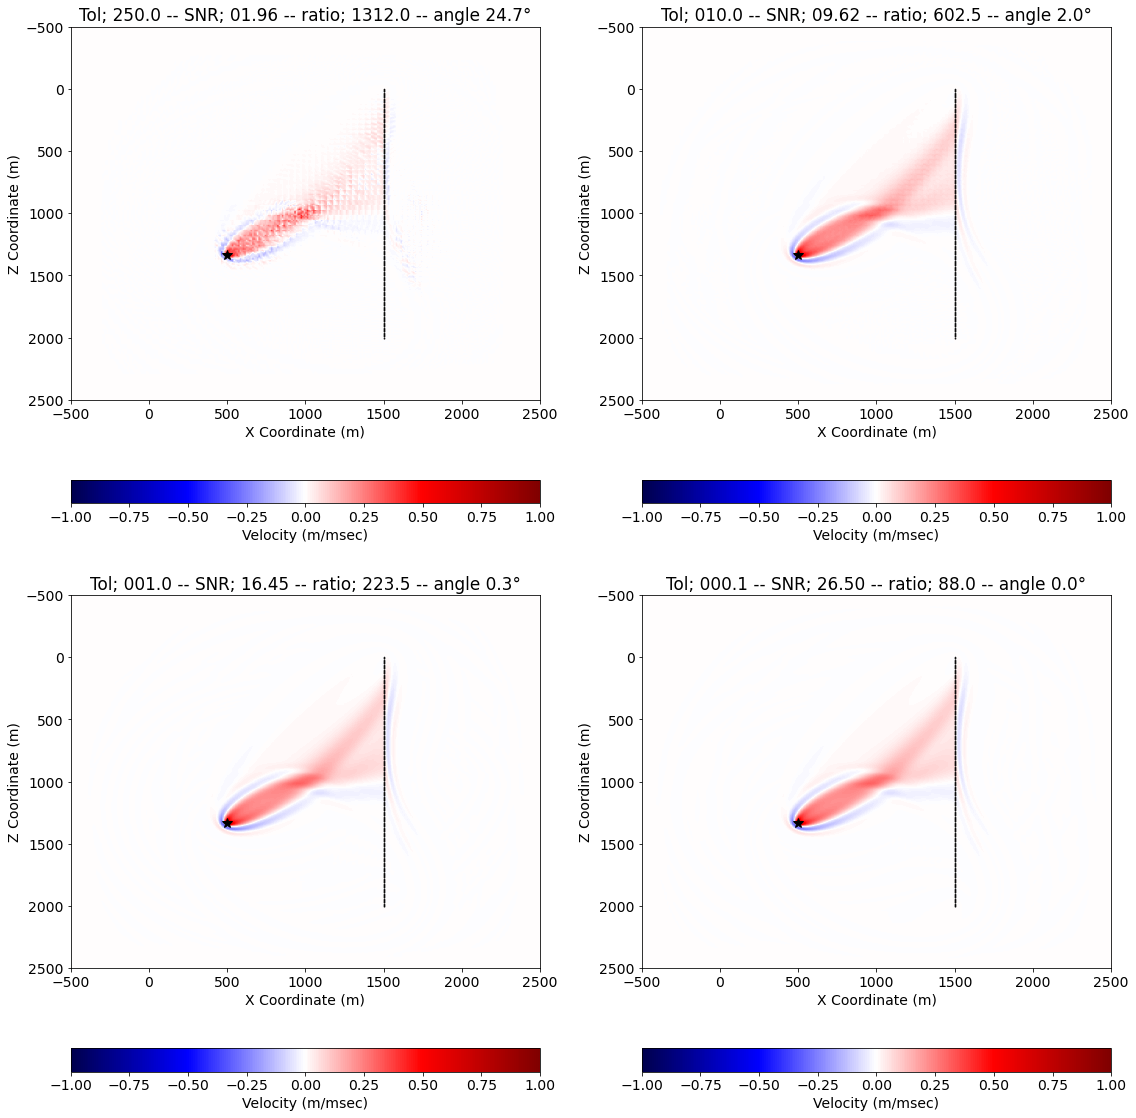

In [251]:
# NBVAL_IGNORE_OUTPUT

ginf = gdict["inf"]
amax =  max(amax, np.max(np.abs(ginf.data[:])))
print("amax; ", amax)

plt.figure(figsize=(16,16))

iplot = 0
for snr in snrs:
    if snr != "inf":
        g = gdict[snr]
        dot  = np.dot(ginf.data.reshape(-1), g.data.reshape(-1))
        ninf = np.linalg.norm(ginf.data.reshape(-1))
        n    = np.linalg.norm(g.data.reshape(-1))
        angr = np.arccos(dot / (np.linalg.norm(ginf.data.reshape(-1)) * np.linalg.norm(g.data.reshape(-1))))
        angd = angr * 180 / np.pi
        print("dot,ninf,n,angr,angd; %+12.6e %+12.6e %+12.6e %+12.6f %+12.6f" % (dot, ninf, n, angr, angd))

        iplot = iplot + 1
        plt.subplot(2, 2, iplot)

        plt.imshow(np.transpose(g.data / amax), cmap="seismic", 
                   vmin=-1, vmax=+1, extent=plt_extent, aspect="auto")
        plt.plot(src0.coordinates.data[:, 0], src0.coordinates.data[:, 1], \
                 'black', linestyle='None', marker='*', markersize=10, label="Source")
        plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
                 'black', linestyle='None', marker='^', markersize=1, label="Receivers")
        plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
        plt.xlabel("X Coordinate (m)")
        plt.ylabel("Z Coordinate (m)")
        label = 'Tol; %05.1f -- SNR; %s -- ratio; %.1f -- angle %.1f\N{DEGREE SIGN}' % (toldict[snr], snr, ratiodict[snr], angd)
        plt.title(label)

plt.tight_layout()
plt.show()